In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
city_data = pd.read_csv("city_data.csv").iloc[:, 1:]
shootings = pd.read_csv("PoliceKillingsUS.csv")

valid_cities = shootings[['state','city']]


cluster_data = city_data.merge(valid_cities.drop_duplicates(), how="inner", left_on = ['Geographic Area','City'], 
                               right_on = ['state', 'city'])

cluster_data.drop(columns=['Geographic Area','City'], inplace=True)

for col in cluster_data.columns[:-2]:
    cluster_data[col] = np.log(cluster_data[col]+1)
    cluster_data[col] = (cluster_data[col]-cluster_data[col].min())/(cluster_data[col].max()-cluster_data[col].min())

data = cluster_data.iloc[:,:-2]
pca=PCA()
pca.fit(data)
pca=PCA(n_components=2)
pca.fit(data)
scores_pca = pca.transform(data)

In [4]:
import math
# import math lib
from math import pi
# import Qiskit
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [12]:
backend = Aer.get_backend('qasm_simulator')
def get_theta(d):
    x = d[0]
    y = d[1]
    
    theta = 2*math.acos((x+y)/2.0)
    return theta

def get_Distance(x,y):
    theta_1 = get_theta(x)
    theta_2 = get_theta(y)
    
    # create Quantum Register called "qr" with 3 qubits
    qr = QuantumRegister(3, name="qr")
    # create Classical Register called "cr" with 5 bits
    cr = ClassicalRegister(3, name="cr")

    # Creating Quantum Circuit called "qc" involving your Quantum Register "qr"
    # and your Classical Register "cr"
    qc = QuantumCircuit(qr, cr, name="k_means")
    
    qc.h(qr[0])
    qc.h(qr[1])
    qc.h(qr[2])
    qc.u3(theta_1, pi, pi, qr[1])
    qc.u3(theta_2, pi, pi, qr[2])
    qc.cswap(qr[0], qr[1], qr[2])
    qc.h(qr[0])

    qc.measure(qr[0], cr[0])
    qc.reset(qr)

    #print('----before run----')
    job = execute(qc,backend=backend, shots=1024)
    #print('----after run----')
    result = job.result()
    data = result.data()['counts']
    
    if len(data)==1:
        return 0.0
    else:
        return data['0x1']/1024.0

In [13]:
def draw_plot(points,centers,label=True):
    if label==False:
        plt.scatter(points[:,0], points[:,1])
    else:
        plt.scatter(points[:,0], points[:,1], c=centers, cmap='viridis')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    
def plot_centroids(centers):
    plt.scatter(centers[:,0], centers[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

def initialize_centers(points,k):
    return points[np.random.randint(points.shape[0],size=k),:]

def get_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)*(p1-p2)))

def find_nearest_neighbour(points,centroids):    
    n = len(points)
    k = centroids.shape[0]
    centers = np.zeros(n)    
    for i in range(n):
        min_dis = 10000
        ind = 0
        for j in range(k):            
            temp_dis = get_Distance(points[i,:],centroids[j,:])            
            if temp_dis < min_dis:
                min_dis = temp_dis
                ind = j
        centers[i] = ind    
    return centers

def find_centroids(points,centers):
    n = len(points)
    k = int(np.max(centers))+1   
    centroids = np.zeros([k,2])    
    for i in range(k):
        #print(points[centers==i])
        centroids[i,:] = np.average(points[centers==i])
        
    return centroids

def preprocess(points):
    n = len(points)
    x = 30.0*np.sqrt(2)
    for i in range(n):
        points[i,:]+=15
        points[i,:]/=x
    
    return points

<ipython-input-12-e6d82c076af9>:25: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(theta_1, pi, pi, qr[1])


<Figure size 432x288 with 0 Axes>

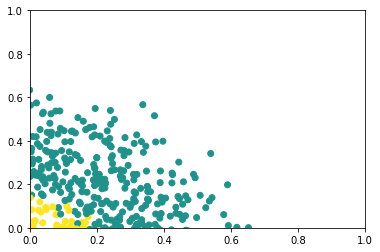

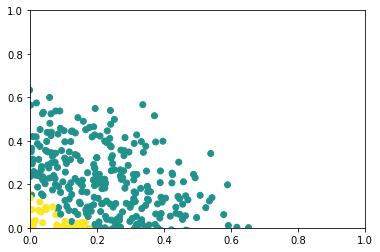

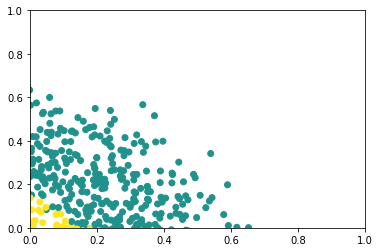

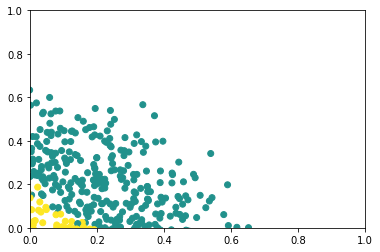

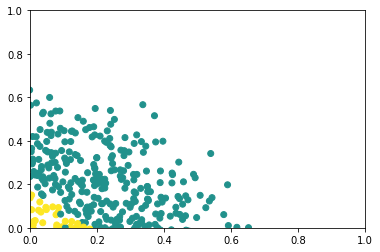

In [14]:
k=3
plt.figure()
centroids = initialize_centers(scores_pca,k)
for i in range(5):
    centers = find_nearest_neighbour(scores_pca,centroids)       # find nearest centers
    plt.figure()
    draw_plot(scores_pca,centers)
    #plot_centroids(centroids)
    centroids = find_centroids(scores_pca,centers) 